# WUMI-MODIS fire dataframe

Author: Jatan Buch (v1, 240627)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats, interpolate
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from math import factorial
import itertools

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping, LineString
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *
from stats_utils import uni_lsq_regression_model, multi_regression_model

from datetime import datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir= "../data/"
pred_input_path= "12km/"
resp_input_path= "firelist/"
outfilepath= "../plots/"

In [3]:
wildfire_df= pd.read_csv(data_dir + resp_input_path + "west_US_fires_1984-2020_WUMI2.txt", 
                         usecols= (1, 2, 18, 19, 20, 21, 22, 23, 24, 25), delimiter= ',') #west_US_fires_1984_2020.txt # WUMI1 cols: (0, 1, 9, 18, 19, 20, 21, 22, 23, 24)
#wildfire_df= wildfire_df[wildfire_df['final_area_ha'] > 404].reset_index()

wildfire_x, wildfire_y= coord_transform(wildfire_df['final_lon'], wildfire_df['final_lat'])
wildfire_df['final_x']= wildfire_x
wildfire_df['final_y']= wildfire_y
wildfire_gdf= gpd.GeoDataFrame(wildfire_df, crs= 'EPSG:5070', geometry=gpd.points_from_xy(wildfire_df['final_x'], wildfire_df['final_y']))

# Append fire data for 2021-2023 from MODIS to wildfire_gdf
burnarea_modis_nc= xarray.open_dataarray(data_dir + '1km/burnarea_MODISv61_2023.nc')
fire_modis_gdf= init_fire_modis_gdf(burnarea_modis_nc, start_year= 2001, nn= 3)
fire_modis_gdf= fire_modis_gdf[fire_modis_gdf.final_area_ha >= 100].reset_index(drop= True)
# wildfire_gdf= wildfire_gdf.append(fire_modis_gdf, ignore_index= True)

reg_indx_arr_wumi2= update_reg_indx(wildfire_gdf)
reg_indx_arr_modis= update_reg_indx(fire_modis_gdf)
# l4indx_arr= update_reg_indx(wildfire_gdf, lflag= 'L4')

wildfire_gdf['reg_indx']= reg_indx_arr_wumi2
fire_modis_gdf['reg_indx']= reg_indx_arr_modis
# wildfire_gdf['L4_indx']= l4indx_arr
# grouped= wildfire_gdf.groupby(['reg_indx'])
# wildfire_gdf.drop(columns= ['geometry']).to_hdf('../data/firelist/wildfire_df_wumi2_modis.h5', key= 'df', mode= 'w')

100%|██████████| 18/18 [01:10<00:00,  3.93s/it]


In [4]:
wumi2_freq= [len(wildfire_gdf[wildfire_gdf.reg_indx > 0].groupby('final_year').get_group(y)) for y in range(2001, 2021)]
modis_freq= [len(fire_modis_gdf[fire_modis_gdf.reg_indx > 0].groupby('final_year').get_group(y)) for y in range(2001, 2024)]

In [5]:
np.sum(wumi2_freq), np.sum(modis_freq[:-3])

(11957, 12784)

Text(0.5, 1.0, 'MODIS: 12784; WUMI2: 11957 (2001-2020)')

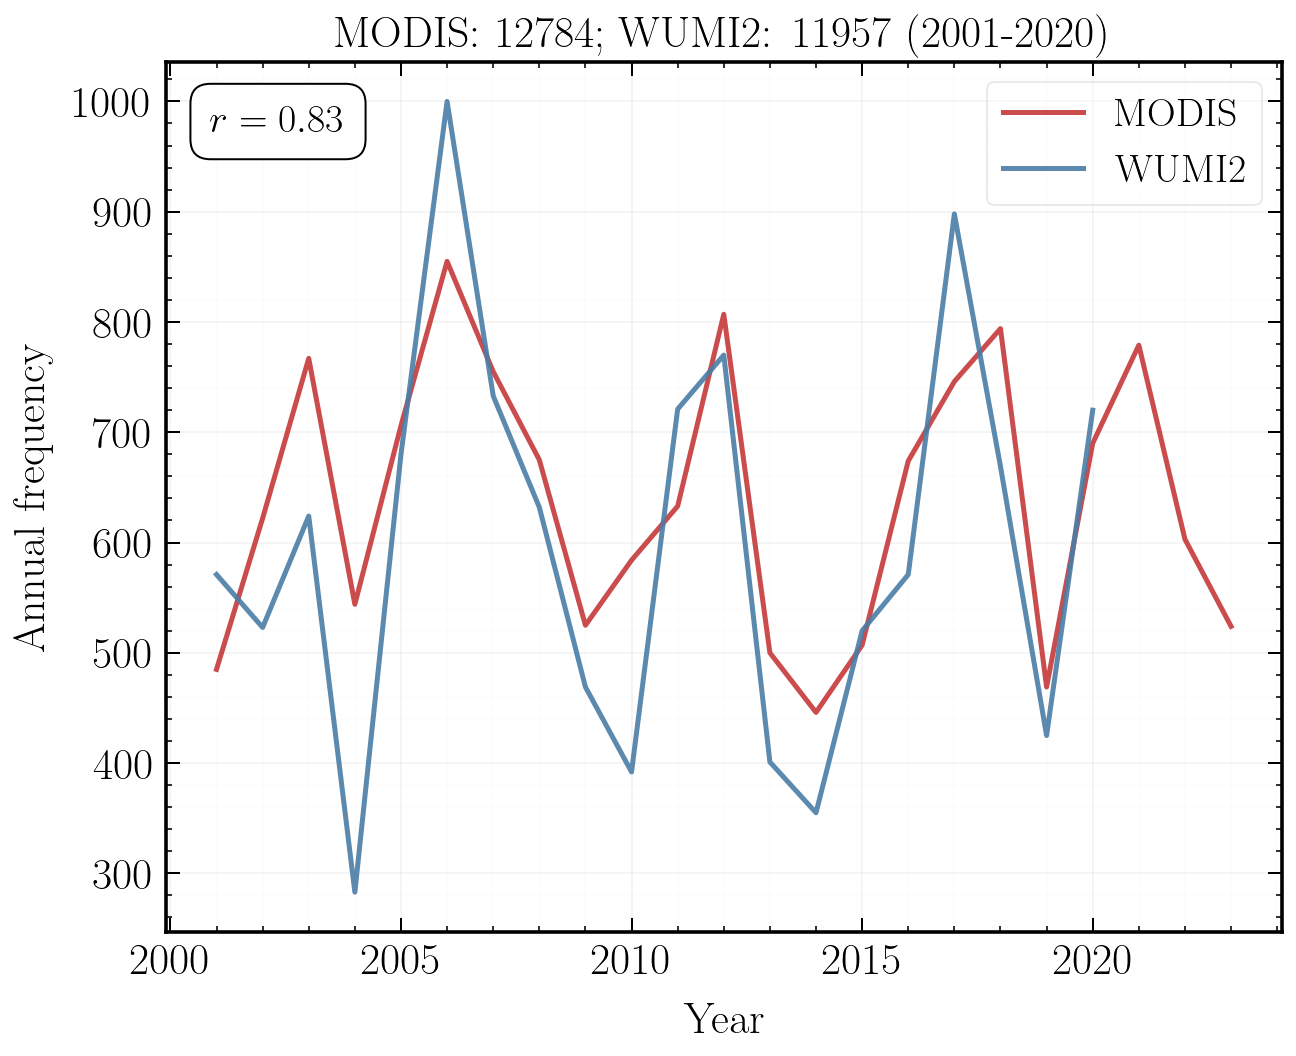

In [6]:
fig, ax= plt.subplots(figsize=(10, 8))

plt.plot(np.linspace(2001, 2023, 23), modis_freq, label= 'MODIS');
plt.plot(np.linspace(2001, 2020, 20), wumi2_freq, label= 'WUMI2');
plt.xlabel('Year', fontsize= 22);
plt.ylabel('Annual frequency', fontsize= 22);
ax.text(0.04, 0.92, r'$r = %.2f$'%stats.pearsonr(wumi2_freq, modis_freq[:-3])[0], fontsize= 20, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax.transAxes)
ax.legend(loc='upper right', frameon= True, fontsize= 20);
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');
plt.title('MODIS: 12784; WUMI2: 11957 (2001-2020)', fontsize= 22)
#plt.savefig('../plots/wumi2_modis_fire_freq_wus.pdf', bbox_inches='tight', dpi= 300);